In [1]:
from fileinput import filename
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pystrata
import pyexcel
import json

from pystrata.motion import TimeSeriesMotion
from pystrata.site import Profile
from PIL import Image

from fileloaders import time_accel_txt_to_pystrata_motion

from dataclasses import dataclass
from dataclasses_json import dataclass_json

from lampa.input import PyStrataInput
from lampa.input import LampaTimeSeriesMotion
from lampa.input import LampaSoilType, LampaDarendeliSoilType
from lampa.input import LampaLayer

## Διέγερση

In [2]:
# ts = time_accel_txt_to_pystrata_motion('Kocaeli.txt')

In [3]:
lts = LampaTimeSeriesMotion.from_txt('Kocaeli.txt')
lts

LampaTimeSeriesMotion(description='', time_step=0.005, accels=array([5.890857e-06, 6.174527e-06, 6.471501e-06, ..., 1.994855e-03,
       2.009481e-03, 2.024089e-03]))

### Εδαφικές στρώσεις

In [4]:
lst1 = LampaSoilType(name='Loose Sand', unit_wt=16.0, damping=0.05)
lst2 = LampaSoilType(name='Clay', unit_wt=18.0, damping=0.05)
lst3 = LampaSoilType(name='Dense Sand', unit_wt=20.0, damping=0.05)
lst4 = LampaSoilType(name='Rock', unit_wt=23.0, damping=0.02)

In [5]:
lli1 = LampaLayer(layer_type='SoilType',
                  layer_properties=lst1,
                  thickness=5,
                  shear_vel=140)

lli2 = LampaLayer(layer_type='SoilType',
                  layer_properties=lst2,
                  thickness=15,
                  shear_vel=250)

lli3 = LampaLayer(layer_type='SoilType',
                  layer_properties=lst3,
                  thickness=30,
                  shear_vel=450)

lli4 = LampaLayer(layer_type='SoilType',
                  layer_properties=lst4,
                  thickness=0,
                  shear_vel=1200)

In [6]:
psi = PyStrataInput(name = 'test1',
                    calculator_type='Elastic',
                    time_series_motion=lts,
                    layers=[lli1, lli2, lli3, lli4])

In [7]:
# psi.to_json()


In [8]:
type(psi.to_json())

str

In [9]:
# with open("sample.json", "w") as outfile:
#     outfile.write(psi.to_json())
    
# # print(json.dumps(psi.to_json(), sort_keys=True, indent=4))

In [10]:
# with open('sample.json') as data_file:
#     data_loaded = json.load(data_file)
    
# # data_loaded

In [11]:
# psi_load = PyStrataInput.from_dict(data_loaded)
# psi_load.layers

In [13]:
profile = pystrata.site.Profile([layer.to_pystrata for layer in psi.layers]).auto_discretize()

<AxesSubplot: xlabel='Initial $V_s$ (m/s)', ylabel='Depth (m)'>

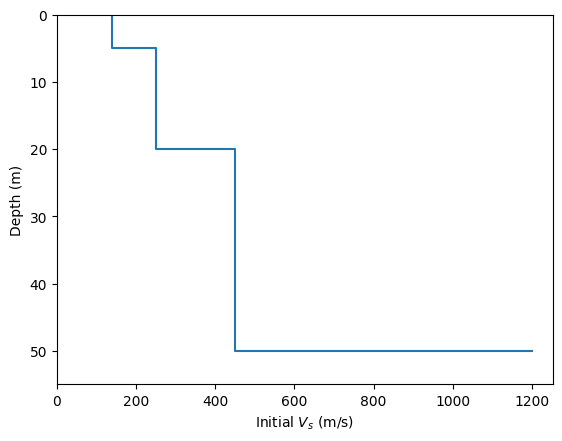

In [14]:
profile.plot("initial_shear_vel")

<AxesSubplot: xlabel='Initial $V_s$ (m/s)', ylabel='Depth (m)'>

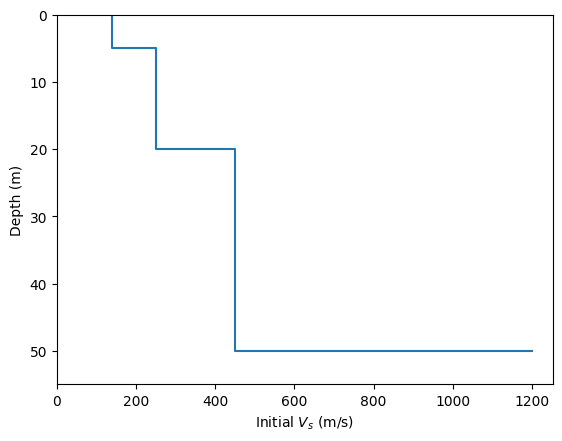

In [16]:
profile2 = psi.to_pystrata_profile
profile2.plot("initial_shear_vel")

In [18]:
freqs = np.logspace(-1, 2, num=113)

outputs = pystrata.output.OutputCollection(
    [
        pystrata.output.ResponseSpectrumOutput(
            # Frequency
            freqs,
            # Location of the output
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ), 
        pystrata.output.AccelTransferFunctionOutput(
            # Frequency
            freqs,
            # Location in (denominator),
            pystrata.output.OutputLocation("outcrop", index=-1),
            # Location out (numerator)
            pystrata.output.OutputLocation("outcrop", index=0),
        ),
       
    ]
)

In [22]:
calc = pystrata.propagation.LinearElasticCalculator()
calc(psi.time_series_motion.to_pystrata, profile, profile.location("outcrop", index=-1))

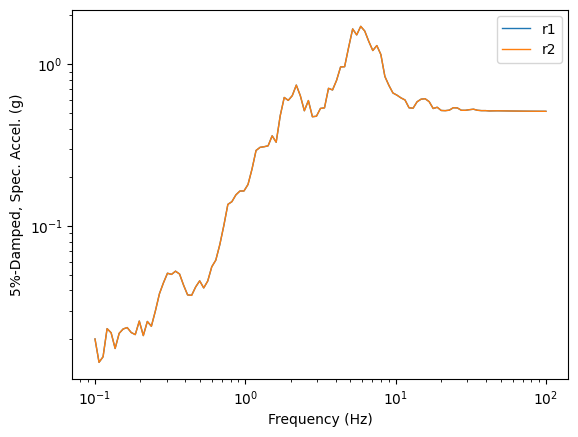

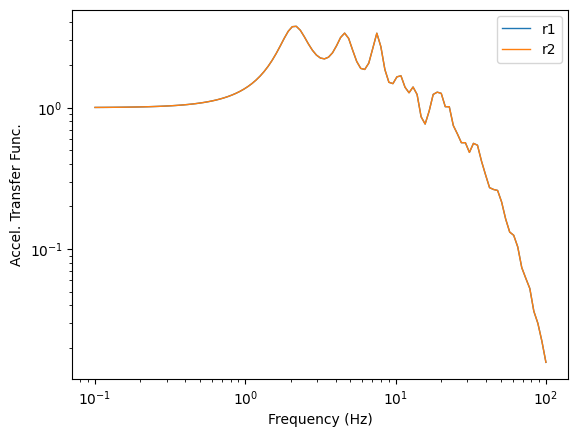

In [24]:
outputs(calc)
for o in outputs:
    o.plot(style="indiv")

In [4]:
ldsti1 = LampaDarendeliSoilType(name='SandDaredeli', unit_wt=16.0)
ldsti1

LampaDarendeliSoilType(name='SandDaredeli', unit_wt=16.0, plas_index=0.0, ocr=1.0, stress_mean=101.3, freq=1.0, num_cycles=10.0)

In [5]:
lli1 = LampaLayer(layer_type='SoilType',
                  layer_properties=lsti,
                  thickness=5,
                  shear_vel=140)

In [6]:
lli1.to_json()

'{"layer_type": "SoilType", "layer_properties": {"name": "Sand", "unit_wt": 16.0, "damping": 0.05}, "thickness": 5, "shear_vel": 140}'

In [7]:
lli2 = LampaLayer(layer_type='DarendeliSoilType',
                  layer_properties=ldsti1,
                  thickness=5,
                  shear_vel=140)
lli2

LampaLayer(layer_type='DarendeliSoilType', layer_properties=LampaDarendeliSoilType(name='SandDaredeli', unit_wt=16.0, plas_index=0.0, ocr=1.0, stress_mean=101.3, freq=1.0, num_cycles=10.0), thickness=5, shear_vel=140)

In [10]:
psi = PyStrataInput(name = 'test1',
                    calculator_type='Elastic',
                    time_series_motion={'times': ts.times, 'accels': ts.accels},
                   layers=[lli1, lli2])

In [13]:
test_psi_json = psi.to_json()

In [14]:
psi2 = psi.from_json(test_psi_json)

In [16]:
psi2.layers

[LampaLayer(layer_type='SoilType', layer_properties={'name': 'Sand', 'unit_wt': 16.0, 'damping': 0.05}, thickness=5, shear_vel=140),
 LampaLayer(layer_type='DarendeliSoilType', layer_properties={'name': 'SandDaredeli', 'unit_wt': 16.0, 'plas_index': 0.0, 'ocr': 1.0, 'stress_mean': 101.3, 'freq': 1.0, 'num_cycles': 10.0}, thickness=5, shear_vel=140)]

In [17]:
ini_file = r'ini.json'
with open(ini_file, 'r') as f:
    input_data = json.load(f)

In [18]:
input_data

{'accel_file': 'Kocaeli.txt', 'strain_limit': 0.02, 'damping': 0.05}

In [19]:
ts = time_accel_txt_to_pystrata_motion('Kocaeli.txt')

In [20]:
ts.accels

array([5.890857e-06, 6.174527e-06, 6.471501e-06, ..., 1.994855e-03,
       2.009481e-03, 2.024089e-03])

In [21]:
input_data['accel_file']

'Kocaeli.txt'

In [24]:
# input_data['accel']['time'] : ts.accels

In [25]:
input_data

{'accel_file': 'Kocaeli.txt', 'strain_limit': 0.02, 'damping': 0.05}

In [26]:
# data = {
#     'employees' : [
#         {
#             'name' : 'John Doe',
#             'department' : 'Marketing',
#             'place' : 'Remote'
#         },
#         {
#             'name' : 'Jane Doe',
#             'department' : 'Software Engineering',
#             'place' : 'Remote'
#         },
#         {
#             'name' : 'Don Joe',
#             'department' : 'Software Engineering',
#             'place' : 'Office'
#         }
#     ]
#     , 'blabla': {'x':4, 'y':5}
# }

In [28]:
# data['blabla']['rrr'] = '3'
# data['blabla']['r44'] = '5'
# data['tt'] = 23

In [29]:
# data

In [30]:
# my_dict = {"username": "XYZ", "email": "xyz@gmail.com", "location":"Mumbai"}

# my_dict['name']='Nick'

# print(my_dict)

In [31]:
# from dataclasses import dataclass

# @dataclass
# class Person:
#     name: str

In [32]:
# p1 = Person(name='John')

In [33]:
# p1

In [34]:
# type(p1)

In [35]:
# ddd = p1.__dict__
# ddd

In [16]:
# @dataclass_json
# @dataclass
# class Person:
#     name: str


# person = Person(name='lidatong')
# person.to_json()  # '{"name": "lidatong"}' <- this is a string
# person.to_dict()  # {'name': 'lidatong'} <- this is a dict
# Person.from_json('{"name": "lidatong"}')  # Person(1)
# Person.from_dict({'name': 'lidatong'})  # Person(1)

In [36]:
# person

In [37]:
# person.to_json()

In [38]:
# person.to_dict() 

In [10]:
@dataclass_json
@dataclass
class PyStrataInput:
    name: str
    time_series_motion: dict[str, np.array]

In [15]:
psi = PyStrataInput(name = 'test1',
                    time_series_motion={'times': ts.times, 'accels': ts.accels})

In [14]:
jjj = psi.to_json()
# jjj

In [25]:
psi2 = PyStrataInput.from_json(jjj)

In [1]:
from lampa.input import Input



In [4]:
list_layers = []

list_layers.append(pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(16.0, plas_index=0, ocr=1, stress_mean=40),
            5,
            140,
        ))

list_layers.append(pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=25, ocr=1, stress_mean=215),
            15,
            250,
        ))

list_layers.append(pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(20.0, plas_index=0, ocr=1, stress_mean=650),
            30,
            450,
        ))

list_layers.append(pystrata.site.Layer(pystrata.site.SoilType("Rock", 23.0, None, 0.02), 0, 1200))




In [6]:
# iii = Input(time_series_motion=ts,
#            site_layers=list_layers,
#            calculator=pystrata.propagation.EquivalentLinearCalculator())

In [7]:
# calc = iii.do_the_calcs()

In [27]:
from lampa.input import PyStrataInput as pppp

In [30]:
psi3 = pppp.from_json(jjj)

In [31]:
psi3


PyStrataInput(name='test1', time_series_motion={'a': [5.890857e-06, 6.174527e-06, 6.471501e-06, 6.786627e-06, 7.112279e-06, 7.421058e-06, 7.722031e-06, 8.039471e-06, 8.354606e-06, 8.708577e-06, 9.060829e-06, 9.302804e-06, 9.524216e-06, 9.82661e-06, 1.016261e-05, 1.053076e-05, 1.107308e-05, 1.153103e-05, 1.161684e-05, 1.166346e-05, 1.196516e-05, 1.236145e-05, 1.269394e-05, 1.297818e-05, 1.329374e-05, 1.360945e-05, 1.410188e-05, 1.489839e-05, 1.508299e-05, 1.509158e-05, 1.584041e-05, 1.614557e-05, 1.590278e-05, 1.595938e-05, 1.671198e-05, 1.794089e-05, 1.799729e-05, 1.773774e-05, 1.874449e-05, 1.907243e-05, 1.850163e-05, 1.839504e-05, 1.937259e-05, 2.145154e-05, 2.357535e-05, 2.52975e-05, 2.458587e-05, 2.160815e-05, 2.066052e-05, 2.289444e-05, 2.342828e-05, 2.197298e-05, 2.156152e-05, 2.232979e-05, 2.362607e-05, 2.646356e-05, 2.817962e-05, 2.588672e-05, 2.417212e-05, 2.739085e-05, 3.111322e-05, 3.099027e-05, 2.621528e-05, 2.126957e-05, 2.251022e-05, 2.65271e-05, 2.752409e-05, 2.886252e-0